# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["KERAS_BACKEND"] = "torch"

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Rescaling, Dropout, Resizing
from keras.layers import RandomFlip, RandomTranslation, RandomRotation, RandomZoom, MultiHeadAttention, AugMix, RandAugment
from keras.models import Sequential
from keras.metrics import F1Score, Precision, AUC
from keras.losses import CategoricalFocalCrossentropy, BinaryFocalCrossentropy, CategoricalCrossentropy
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.optimizers.schedules import ExponentialDecay, CosineDecay
from keras.optimizers import AdamW

from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN, KMeansSMOTE
from imblearn.under_sampling import TomekLinks, RepeatedEditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.utils import compute_class_weight

from PIL import Image

# Move images into class folders

In [ ]:
def move_and_separate_images(list_of_folders, df_metadata):
    df_metadata = df_metadata.set_index('image_id', drop=True)
    count = 0
    for folder in list_of_folders:
        for root, dirs, files in os.walk(folder):
            for file in files:
                try:
                    os.makedirs(f"dataset/{df_metadata.loc[file.strip('.jpg'), 'dx']}")
                except:
                    source=os.path.join(root, file)
                    destination=os.path.join('dataset', df_metadata.loc[file.strip('.jpg'), 'dx'], file)
                    os.rename(source,destination)
                    count += 1
                    if count%100 == 0:
                        print(f'{count} images were processed')

In [ ]:
df = pd.read_csv('HAM10000_metadata.csv')

move_and_separate_images(['HAM10000_images_part_1', 'HAM10000_images_part_2'], df)

# Move images into cancerous/non cancerous folders

In [ ]:
class_mapping = {
    "akiec": "canc",
    "bcc": "canc",
    "bkl": "nocanc",
    "df": "nocanc",
    "mel": "canc",
    "nv": "nocanc",
    "vasc": "nocanc"
}

In [ ]:
def move_and_separate_images(list_of_folders, df_metadata):
    df_metadata = df_metadata.set_index('image_id', drop=True)
    count = 0
    for folder in list_of_folders:
        for root, dirs, files in os.walk(folder):
            for file in files:
                try:
                    os.makedirs(f"dataset/{class_mapping[df_metadata.loc[file.strip('.jpg'), 'dx']]}")
                except:
                    source=os.path.join(root, file)
                    destination=os.path.join('dataset', class_mapping[df_metadata.loc[file.strip('.jpg'), 'dx']], file)
                    os.rename(source,destination)
                    count += 1
                    if count%100 == 0:
                        print(f'{count} images were processed')

In [ ]:
df = pd.read_csv('HAM10000_metadata.csv')

move_and_separate_images(['HAM10000_images_part_1', 'HAM10000_images_part_2'], df)

# Make arrays

In [ ]:
def array_from_images(folder, df_metadata, dict_of_labels, h=224, w=224, channels=3):
    # Create an array of images and labels the size of the number of pictures
    nb_files = 0
    for root, dirs, files in os.walk(folder):
        for file in files:
            nb_files += 1
    array = np.zeros(shape=(nb_files, h, w, channels))
    labels = np.zeros(shape=(nb_files,))

    # Check the name and fill array and labels
    df_metadata = df_metadata.set_index('image_id', drop=True)
    count = 0

    for root, dirs, files in os.walk(folder):
        for file in files:
            with Image.open(os.path.join(root, file)) as im:
                array[count,:,:,:] = np.asarray(im.resize((h,w)))
                try:
                    labels[count] = dict_of_labels[class_mapping[df_metadata.loc[file.strip('.jpg'), 'dx']]]
                except:
                    labels[count] = dict_of_labels[df_metadata.loc[file.strip('.jpg'), 'dx']]
                count += 1
                if count%100 == 0:
                    print(f'{count} images were processed')
    return array, labels

In [ ]:
class_mapping = {
    "akiec": "canc",
    "bcc": "canc",
    "bkl": "nocanc",
    "df": "nocanc",
    "mel": "canc",
    "nv": "nocanc",
    "vasc": "nocanc"
}

In [ ]:
df = pd.read_csv('HAM10000_metadata.csv')
# dict_label = {k:v for k,v in zip(['nocanc', 'canc'], range(2))}
dict_label = {k:v for k,v in zip(list(class_mapping.keys()), range(7))}
size = 224

X, y = array_from_images('dataset/', df, dict_label, h=size, w=size)


In [ ]:
np.savez_compressed(f'X-{size}x{size}', X, allow_pickle=True)
np.savez_compressed(f'y-{size}x{size}', y, allow_pickle=True)

# Load arrays

In [2]:
size = 224
X = np.load(f'X-{size}x{size}.npz')['arr_0']
y = np.load(f'y-{size}x{size}.npz')['arr_0']

# Compute class weights

In [3]:
class_weights = {i:(len(y)/(7 * sum(y==i))).item() for i in range(7)}
# class_weights = compute_class_weight(class_weight="balanced", classes=np.array(range(7)), y=y)

# Split arrays

In [4]:
from sklearn.model_selection import train_test_split

X_train, X, y_train, y = train_test_split(X, y, stratify=y, test_size=0.2, random_state=38)



X_test, X_val, y_test, y_val = train_test_split(X, y, stratify=y, test_size=0.5, random_state=38)

del X,y

# One Hot Encoding of labels

In [5]:
y_train = to_categorical(y_train, num_classes=7)
y_val = to_categorical(y_val, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

# Helper functions

In [6]:
def get_earlystopping(patience=10):
    early_stopping = EarlyStopping(
    monitor='val_f1_score',
    mode='max',
    patience=patience,
    verbose=1,
    restore_best_weights=True)
    return early_stopping

In [7]:
def plot_learning_curves(model):
    fig, ax = plt.subplots(1,3, figsize=(15,5))
    ax[0].plot(model.history.history['val_f1_score'], label='val_f1_score')
    ax[0].plot(model.history.history['f1_score'], label='f1_score')
    ax[0].legend()
    try:
        ax[1].plot(model.history.history['val_mean_average_precision'], label='val_mean_avg_prec')
        ax[1].plot(model.history.history['mean_average_precision'], label='mean_avg_prec')
        ax[1].legend()
    except:
        pass
    #     ax[1].plot(model.history.history['val_precision_1'], label='val_precision_1')
    #     ax[1].plot(model.history.history['precision_1'], label='precision_1')
    #     ax[1].legend()
    ax[2].plot(model.history.history['val_loss'], label='val_loss')
    ax[2].plot(model.history.history['loss'], label='loss')
    ax[2].legend()
    fig.show;

In [8]:
def get_analysis(model, testX, testy):
    plot_learning_curves(model)
    loss, f1, avg_prec = model.evaluate(testX, testy)
    print(f'The model gave')
    print(f'Loss: {loss:.2f}')
    print(f'F1 Macro: {f1:.2f}')
    print(f'Avg Prec: {avg_prec:.2f}')
    y_pred = model.predict(testX)
    y_res = np.argmax(y_pred, axis=1)
    print(classification_report(testy, y_res))
    return y_pred, y_res

In [9]:
def get_analysis_cat(model, testX, testy):
    plot_learning_curves(model)
    loss, f1 = model.evaluate(testX, testy)
    print(f'The model gave')
    print(f'Loss: {loss:.2f}')
    print(f'F1 Macro: {f1:.2f}')
    # print(f'Avg Prec: {avg_prec:.2f}')
    predy = model.predict(testX)
    resy = to_categorical(np.argmax(predy, axis=1), num_classes=7)
    print(classification_report(testy,resy))
    return predy, resy

In [10]:
def compile_and_train(model, loss, opt, metrics, epochs, patience=None, steps=None, class_weight=None):
    model.compile(loss=loss,
                optimizer=opt,
                metrics=metrics)

    model.summary()

    if patience != None:
        model.fit(
            X_train,
            y_train,
            epochs=epochs,
            validation_data=(X_val, y_val),
            callbacks=[get_earlystopping(patience)],
            steps_per_epoch=steps,
            class_weight=class_weight
            )
    else:
        model.fit(
            X_train,
            y_train,
            epochs=epochs,
            validation_data=(X_val, y_val),
            steps_per_epoch=steps,
            class_weight=class_weight
            )

    return model

# Model

In [11]:
from keras.applications import EfficientNetV2B0, VGG16

effnet = EfficientNetV2B0(
    include_top=True,
    input_shape=X_train.shape[1:],
    weights=None,
    classes=7,
    classifier_activation="softmax",
)

# for layer in effnet.layers:
#     layer.trainable = False

preproc = Sequential([
    RandomFlip(),
    RandomRotation(factor=0.5),
    RandomTranslation(height_factor=0.5, width_factor=0.5),
    RandomZoom(height_factor=0.5, width_factor=0.5)
])

model = Sequential([
    Input(shape=(X_train.shape[1:])),
    Rescaling(scale=1./255),
    # RandAugment(value_range=(0,1), num_ops=1, factor=0.1),
    preproc,
    effnet, 
    # Dropout(0.2),
    # Flatten(),
    # Dense(16, activation='relu'),
    # Dense(7, activation='softmax')
])

In [12]:
def mean_average_precision(y_true, y_pred):
    aps = []
    for c in range(7):
        ap = average_precision_score(y_true.detach().cpu().numpy()[:, c], y_pred.detach().cpu().numpy()[:, c])
        aps.append(ap)

    mAP = sum(aps) / len(aps)
    return mAP


In [13]:
lr_schedule = CosineDecay(initial_learning_rate=1e-4, decay_steps=500, alpha=0.1) 
optimizer = AdamW(learning_rate=lr_schedule, weight_decay=0.01)


history020 = compile_and_train(model,
                               loss=CategoricalCrossentropy(),
                               opt=optimizer,
                               metrics=[F1Score(average='macro')],
                               epochs=500,
                               patience=100, 
                               class_weight=class_weights
                )

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7)              │     5,928,279 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,928,279 (22.61 MB)

 Trainable params: 5,867,671 (22.38 MB)

 Non-trainable params: 60,608 (236.75 KB)

Epoch 1/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 47s 175ms/step - f1_score: 0.0802 - loss: 2.7685 - val_f1_score: 0.0285 - val_loss: 2.6040
Epoch 2/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 43s 167ms/step - f1_score: 0.0948 - loss: 2.4048 - val_f1_score: 0.0478 - val_loss: 2.1210
Epoch 3/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - f1_score: 0.1065 - loss: 2.3076 - val_f1_score: 0.0285 - val_loss: 2.2823
Epoch 4/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 43s 167ms/step - f1_score: 0.1109 - loss: 2.3185 - val_f1_score: 0.0285 - val_loss: 2.3514
Epoch 5/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 43s 167ms/step - f1_score: 0.1208 - loss: 2.3697 - val_f1_score: 0.0367 - val_loss: 1.9827
Epoch 6/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 43s 167ms/step - f1_score: 0.1313 - loss: 2.3015 - val_f1_score: 0.1061 - val_loss: 1.9039
Epoch 7/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 43s 167ms/step - f1_score: 0.1314 - loss: 2.2870 - val_f1_score: 0.0613 - val_loss: 2.1055
Epoch 8/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 165ms/step - f1_score: 0.1355 -

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - f1_score: 0.4883 - loss: 0.8685
The model gave
Loss: 0.87
F1 Macro: 0.49
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step
              precision    recall  f1-score   support

           0       0.25      0.39      0.31        33
           1       0.31      0.55      0.40        51
           2       0.52      0.37      0.43       110
           3       0.24      0.67      0.35        12
           4       0.36      0.37      0.36       111
           5       0.87      0.80      0.83       670
           6       0.69      0.79      0.73        14

   micro avg       0.68      0.68      0.68      1001
   macro avg       0.46      0.56      0.49      1001
weighted avg       0.72      0.68      0.69      1001
 samples avg       0.68      0.68      0.68      1001



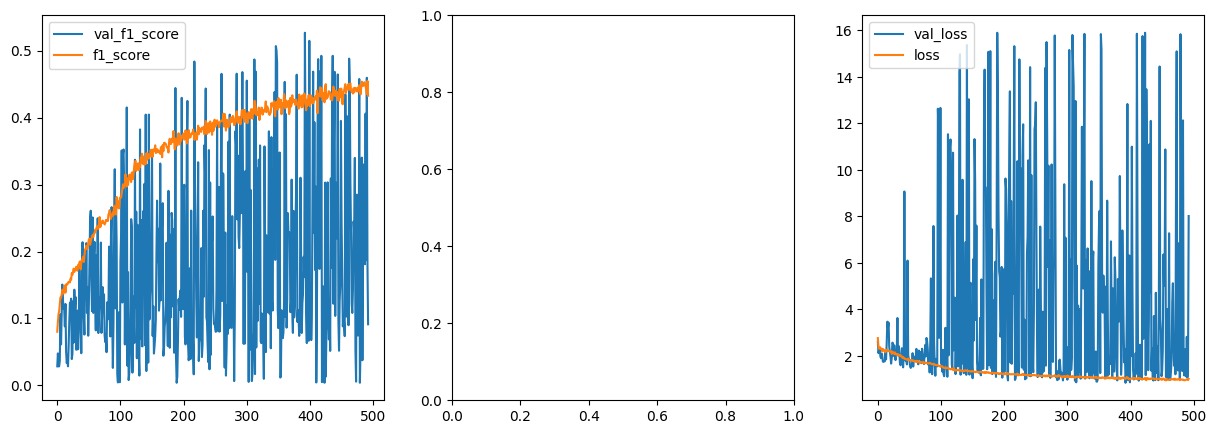

In [14]:
pred, res = get_analysis_cat(model, X_test, y_test)

In [15]:
torch.save(model, "model_v2b0_224px_f1_preproc_weighted_lr1e-4_patience100.pth")

In [ ]:
np.mean(list(class_weights.values()))